# OpenAI o3
---


In [1]:
# Imports
import os
import sys
import numpy as np
import ipywidgets as widgets
from IPython.display import display

sys.path.append(r"C:\Users\janbe\Documents\GitHub Repos\pulse")
from src.eval.llm_analyzer import LLMAnalyzer
from src.eval.pulse_score import PULSEScoreCalculator

## Analysis of different prompting approaches
---

In [3]:
import pandas as pd


model_id = "o3"
base_output_dir = (
    r"C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark"
)
model_output_dir = os.path.join(base_output_dir, "llms", model_id)
results_output_dir = os.path.join(base_output_dir, r"results_output")


prompt_approaches = os.listdir(model_output_dir)
print(prompt_approaches)

# Try to load results_dict from json before calculating
results_loaded = False
results_output_jsons = os.path.join(results_output_dir, "jsons")
results_json_path = f"{model_id}_results.json"

if not results_loaded:
    best_prompt_approach = None

    results_dict = {}
    cost_df = pd.DataFrame()

    for prompt_approach in prompt_approaches:

        if not os.path.isdir(os.path.join(model_output_dir, prompt_approach)):
            continue

        print("=" * 50)
        print(f"\nPrompting Approach {prompt_approach}")

        cat_files = LLMAnalyzer.categorize_files(
            [os.path.join(model_output_dir, prompt_approach)],
            verbose=False,
        )

        df_mdata = LLMAnalyzer.load_metadata(cat_files["metadata_files"], verbose=True)
        summary = LLMAnalyzer.print_approach_summary(
            df_mdata, input_token_cost=2, output_token_cost=8
        )

        # Filter for final prediction step if agent is used

        if "Step Name" in df_mdata.columns:

            df_mdata = df_mdata[
                df_mdata["Step Name"] == "final_prediction"
            ].reset_index(drop=True)

        ps = PULSEScoreCalculator()

        pulse_score = ps.calculate_pulse_score_from_raw_data(
            df=df_mdata,
        )
        pulse_score["model_id"] = model_id
        pulse_score["prompting_id"] = prompt_approach

        pulse_score_temp = pulse_score["overall"]["overall_score"]

        results_dict[prompt_approach] = pulse_score
        cost_df[prompt_approach] = [
            summary["input_cost"].sum(),
            summary["output_cost"].sum(),
            summary["thinking_cost"].sum(),
            summary["total_cost"].sum(),  # Reasoning Tokens are billed as output tokens
        ]
        cost_df.index = ["input_cost", "output_cost", "thinking_cost", "total_cost"]

        if best_prompt_approach is None or pulse_score_temp > best_prompt_approach[1]:

            best_prompt_approach = (prompt_approach, pulse_score_temp)

    display(cost_df)

    print(
        f"\nBest prompt approach: {best_prompt_approach[0]} with PULSE score: {best_prompt_approach[1]}"
    )

    # Save results as json. Uses pulse-result format
    json_output_path = os.path.join(results_output_jsons, f"{model_id}_results.json")
    LLMAnalyzer.save_results_dict_as_json(
        results_dict, model_output_dir, json_output_path
    )

['hybrid_reasoning_agent_preprocessor', 'liu_2023_few_shot_preprocessor', 'zhu_2024b_one_shot_preprocessor', 'zhu_2024b_zero_shot_preprocessor']

Prompting Approach hybrid_reasoning_agent_preprocessor
Model Name: OpenAIo3, Task: aki, Dataset: eicu, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: aki, Dataset: hirid, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: aki, Dataset: miiv, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: mortality, Dataset: eicu, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: mortality, Dataset: hirid, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: mortality, Dataset: miiv, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: sepsis, Dataset: eicu, Timestamp: 20250711_111851
Model Name: OpenAIo3, Task: sepsis, Dataset: hirid, Timestamp: 20250711_111851
Model Name: OpenAIo3, Task: sepsis, Dataset: miiv, Timestamp: 20250711_111851
Number of Samples: 5896
Number of requests: 25250
Number of input tokens: 16022702
Number of o

,hybrid_reasoning_agent_preprocessor,liu_2023_few_shot_preprocessor,zhu_2024b_one_shot_preprocessor,zhu_2024b_zero_shot_preprocessor
input_cost,32.045404,108.101850,69.369396,43.443884
output_cost,86.254280,39.215632,37.204216,37.117144
thinking_cost,0.000000,295.271424,274.581504,275.033088
total_cost,118.299684,442.588906,381.155116,355.594116



Best prompt approach: hybrid_reasoning_agent_preprocessor with PULSE score: 57.043574985578466
Saved 36 result entries to C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark\results_output\jsons\o3_results.json


Summary Metrics of all Prompting Appraches

C:\Users\janbe\Documents\GitHub Repos\pulse\src\eval\llm_analyzer.py:916: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = plot_df.groupby(["Group", "Metric"], as_index=False).agg(


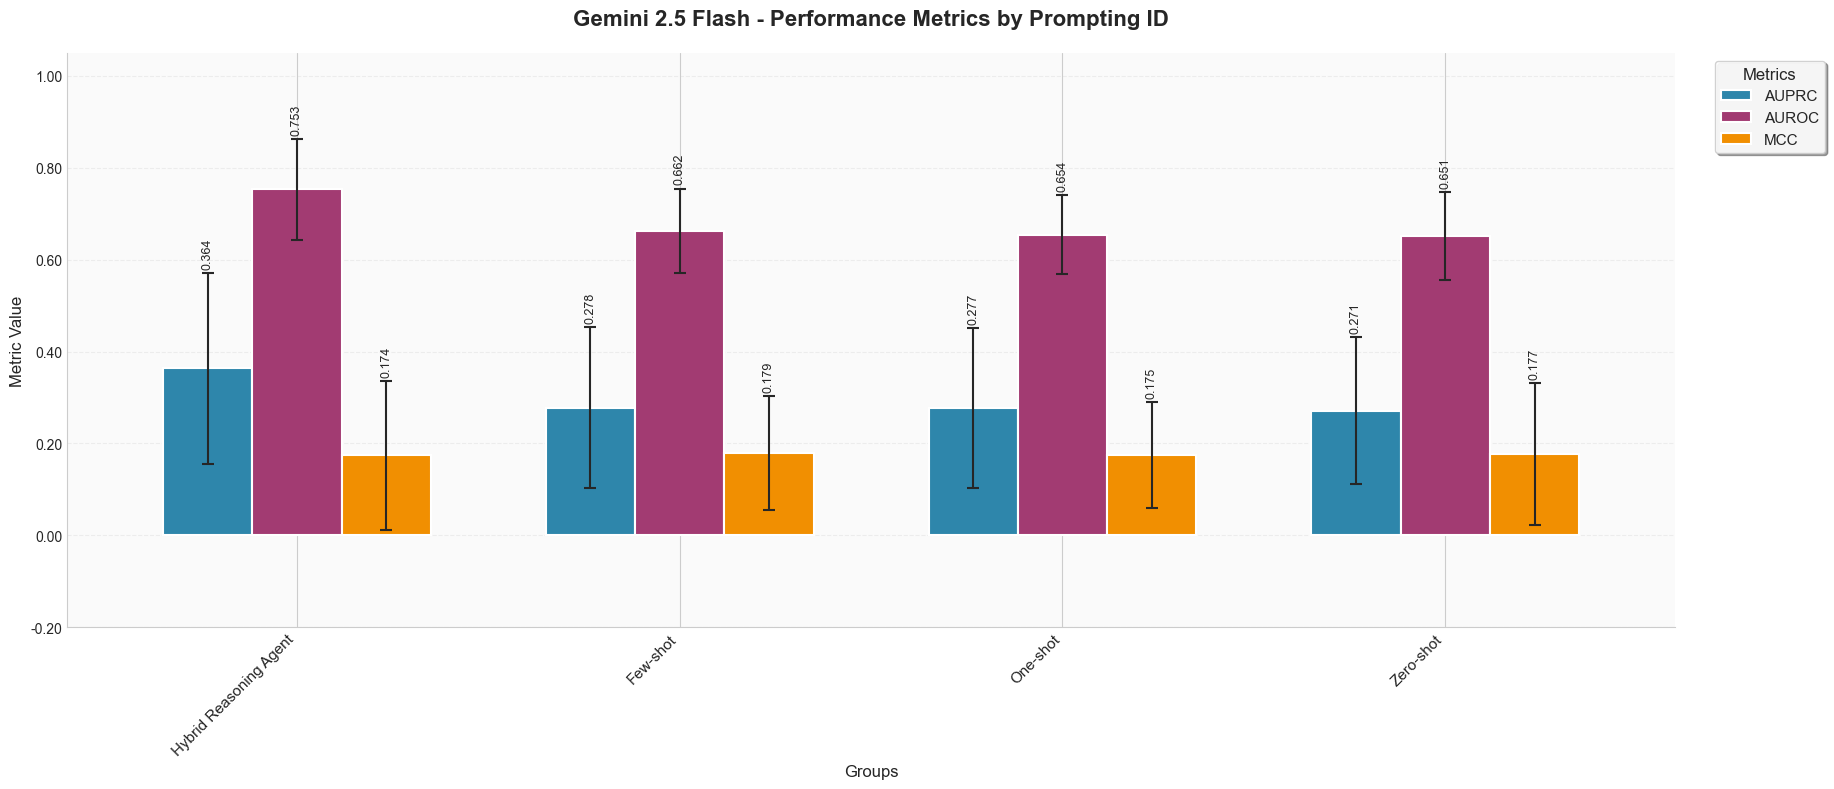

In [4]:
df_results = LLMAnalyzer.load_metrics_from_prompt_approaches(
    model_output_dir, prompt_approaches
)



LLMAnalyzer.plot_metrics(
    df_results, group=["prompting_id"], title_prefix="Gemini 2.5 Flash - "
)

Metrics per Prompt and Task

C:\Users\janbe\Documents\GitHub Repos\pulse\src\eval\llm_analyzer.py:916: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = plot_df.groupby(["Group", "Metric"], as_index=False).agg(


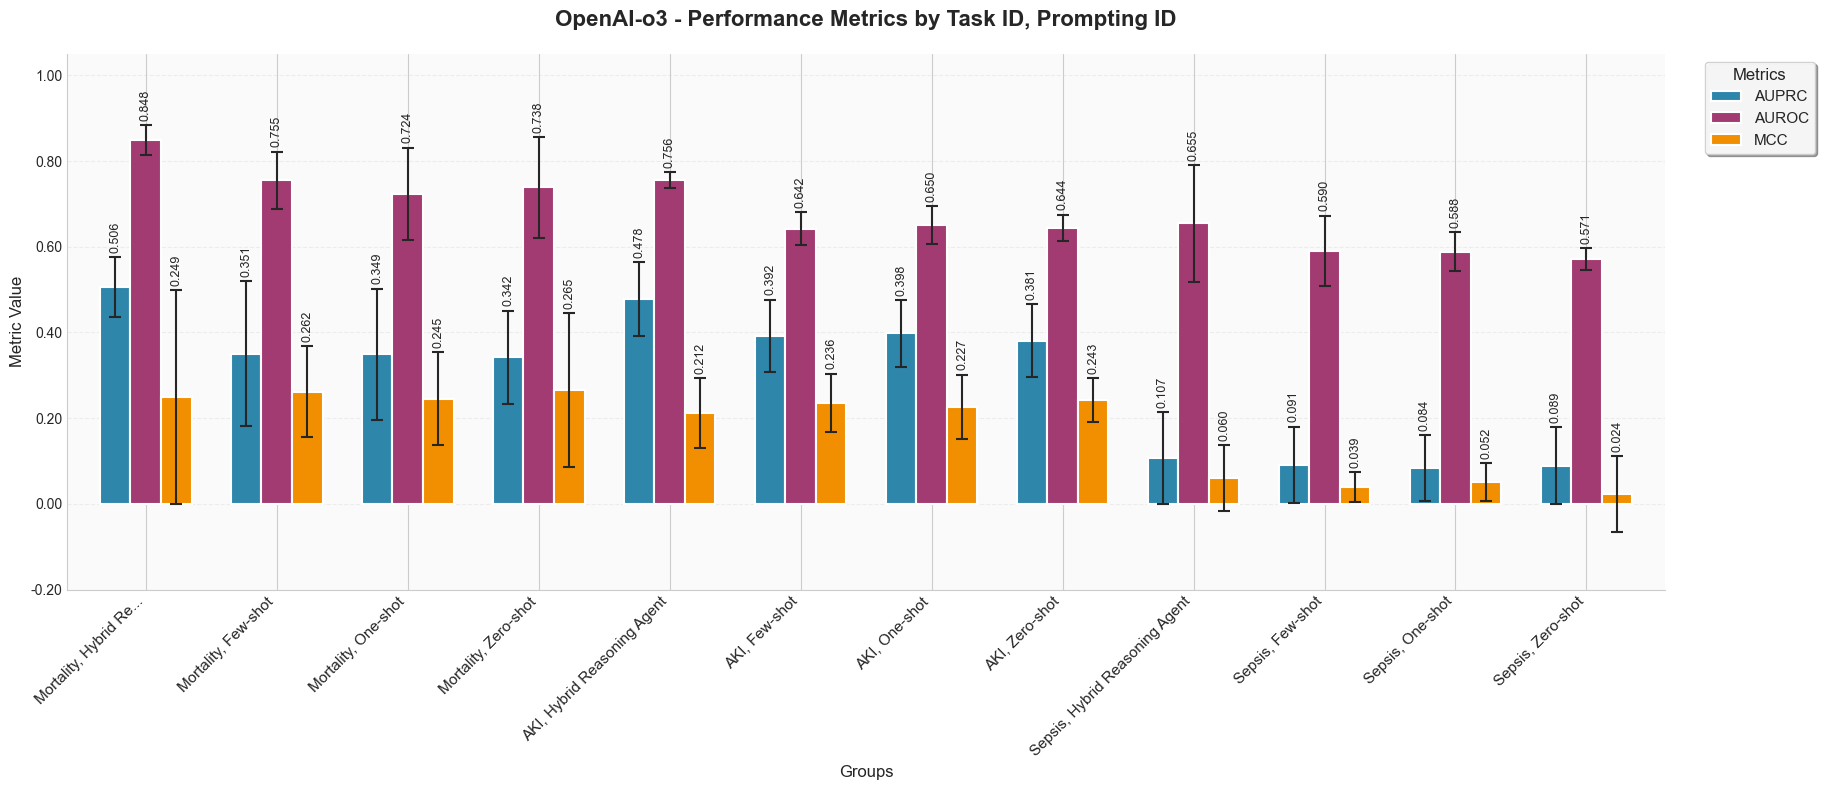

In [5]:
LLMAnalyzer.plot_metrics(
    df_results,
    group=["task_id", "prompting_id"],
    title_prefix="OpenAI-o3 - ",
)

Analysis of best prompting approach

In [6]:
prompt_dropdown = widgets.Dropdown(
    options=prompt_approaches,
    value=best_prompt_approach[0],
    description='Prompt Approach:',
    style={'description_width': 'initial'}
)
display(prompt_dropdown)


Dropdown(description='Prompt Approach:', options=('hybrid_reasoning_agent_preprocessor', 'liu_2023_few_shot_pr…

In [8]:
best_approach_path = os.path.join(
    model_output_dir, prompt_dropdown.value
)
print(f"Loading metadata from: {best_approach_path}")
print("======================================================")
cat_files = LLMAnalyzer.categorize_files([best_approach_path], verbose=False)
df_mdata = LLMAnalyzer.load_metadata(cat_files["metadata_files"])

Loading metadata from: C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark\llms\o3\hybrid_reasoning_agent_preprocessor
Model Name: OpenAIo3, Task: aki, Dataset: eicu, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: aki, Dataset: hirid, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: aki, Dataset: miiv, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: mortality, Dataset: eicu, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: mortality, Dataset: hirid, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: mortality, Dataset: miiv, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: sepsis, Dataset: eicu, Timestamp: 20250711_111851
Model Name: OpenAIo3, Task: sepsis, Dataset: hirid, Timestamp: 20250711_111851
Model Name: OpenAIo3, Task: sepsis, Dataset: miiv, Timestamp: 20250711_111851


In [30]:
print("-" * 50)
print(f"Summary of the approach: {prompt_dropdown.value}")
print_approach_summary(df_mdata)

--------------------------------------------------
Summary of the approach: hybrid_reasoning_agent_preprocessor
Number of Samples: 5896
Number of requests: 25250
Number of input tokens: 16022702
Number of output tokens: 10781785


,task,dataset,mean_inference_time,total_inference_time,mean_input_tokens,total_input_tokens,mean_output_tokens,total_output_tokens,positive_samples,negative_samples,total_samples,pos_neg_ratio
0,aki,eicu,11.301488,51037.517641,661.484500,2987264,443.648361,2003516,1470,3046,4516,0.482600
1,aki,hirid,10.720405,45797.569259,640.603464,2736658,406.926264,1738389,758,3514,4272,0.215709
2,aki,miiv,10.084905,45825.809646,683.939921,3107823,453.829665,2062202,1113,3431,4544,0.324395
3,mortality,eicu,9.523182,3894.981372,604.256724,247141,400.195599,163680,31,378,409,0.082011
4,mortality,hirid,9.472590,3987.960585,643.857482,271064,419.995249,176818,50,371,421,0.134771
5,mortality,miiv,11.140029,4656.531991,628.488038,262708,452.892344,189309,56,362,418,0.154696
6,sepsis,eicu,10.112070,27787.968442,594.822416,1634572,417.573872,1147493,160,2588,2748,0.061824
7,sepsis,hirid,7.499946,29662.285894,611.299621,2417690,428.635904,1695255,315,3640,3955,0.086538
8,sepsis,miiv,6.602052,26190.340086,594.348878,2357782,404.618856,1605123,101,3866,3967,0.026125


--- Prediction Distribution Statistics ---
Total Records: 300
Ground Truth Positive Samples: 30
Ground Truth Negative Samples: 270
Mean Predicted Probability (Average of All Predictions): 0.456
Std Predicted Probability: 0.330
Calibration Error (|Mean Pred. Prob. - Ground Truth Pos. Rate|): 0.356
True Positives: 23
True Negatives: 143
False Positives: 127
False Negatives: 7
Accuracy (at 0.5 threshold): 0.553
AUPRC: 0.482


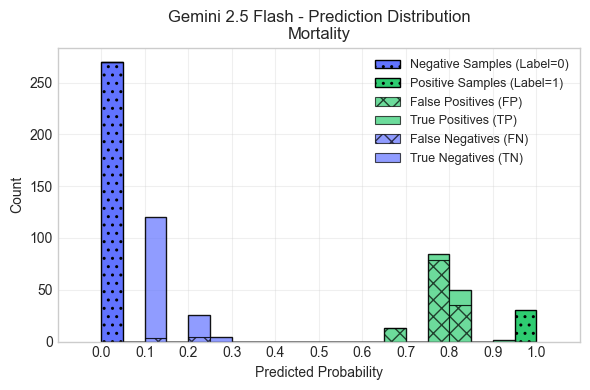

--- Prediction Distribution Statistics ---
Total Records: 2939
Ground Truth Positive Samples: 145
Ground Truth Negative Samples: 2794
Mean Predicted Probability (Average of All Predictions): 0.415
Std Predicted Probability: 0.338
Calibration Error (|Mean Pred. Prob. - Ground Truth Pos. Rate|): 0.366
True Positives: 103
True Negatives: 1761
False Positives: 1032
False Negatives: 42
Accuracy (at 0.5 threshold): 0.635
Could not calculate AUPRC: Input contains NaN.. Make sure sklearn.metrics.average_precision_score is available.


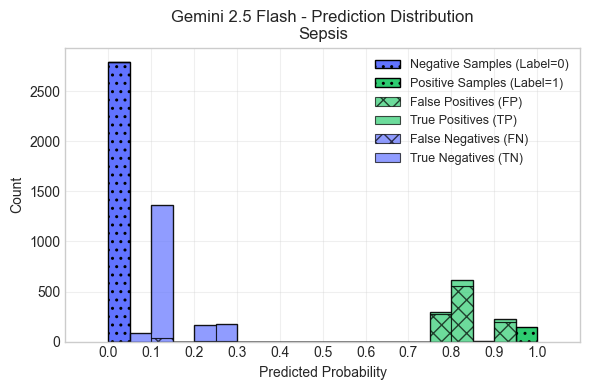

--- Prediction Distribution Statistics ---
Total Records: 2950
Ground Truth Positive Samples: 693
Ground Truth Negative Samples: 2257
Mean Predicted Probability (Average of All Predictions): 0.261
Std Predicted Probability: 0.331
Calibration Error (|Mean Pred. Prob. - Ground Truth Pos. Rate|): 0.026
True Positives: 260
True Negatives: 1897
False Positives: 360
False Negatives: 433
Accuracy (at 0.5 threshold): 0.731
AUPRC: 0.448


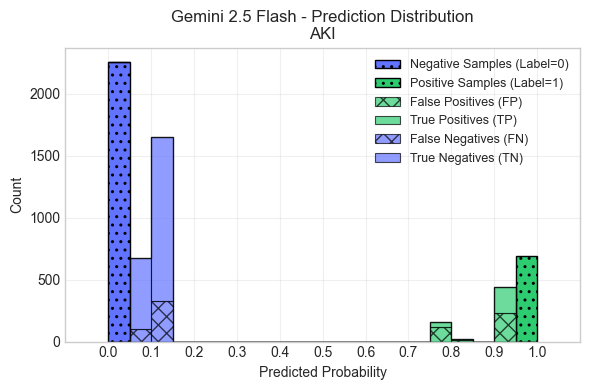

In [12]:
# Distribution of predictions
LLMAnalyzer.plot_prediction_distribution(
    df_mdata,
    title_prefix="Gemini 2.5 Flash - Prediction Distribution",
    data_filter={"task": ["mortality"]},
    show_stats=True,
    color_neg="#6173FF", 
    color_pos="#2ECC71"  
)
LLMAnalyzer.plot_prediction_distribution(
    df_mdata,
    title_prefix="Gemini 2.5 Flash - Prediction Distribution",
    data_filter={"task": ["sepsis"]},
    show_stats=True,
    color_neg="#6173FF",
    color_pos="#2ECC71",
)
LLMAnalyzer.plot_prediction_distribution(
    df_mdata,
    title_prefix="Gemini 2.5 Flash - Prediction Distribution",
    data_filter={"task": ["aki"]},
    show_stats=True,
    color_neg="#6173FF",
    color_pos="#2ECC71",
)

---